# Business Textual Analysis

_You shall know a word by the company it keeps_ - J. R. Firth

Text mining techniques allow new insights to be extracted from unstructured text documents. We retrieve business descriptions text from 10-K filings, and use the **Spacy** NLP package for syntactic analysis, including part-of-speech tagging, named entity recognition and dependency parsing. Additionally, we explore dimentionality reduction techniques to visualize and cluster companies based on the relationships between business descriptions, represented as word embeddings, in a lower-dimensional space.





In [1]:
# By: Terence Lim, 2020-2025 (terence-lim.github.io)
import re
import numpy as np
from scipy import spatial
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import spacy
from sklearn import cluster
from sklearn.decomposition import PCA
from tqdm import tqdm
from finds.database import SQL, RedisDB
from finds.structured import CRSP, BusDay
from finds.unstructured import Edgar
from finds.utils import Store, Finder, ColorMap
from secret import credentials, paths
# %matplotlib qt
VERBOSE = 0

In [2]:
sql = SQL(**credentials['sql'], verbose=VERBOSE)
user = SQL(**credentials['user'], verbose=VERBOSE)
bd = BusDay(sql)
rdb = RedisDB(**credentials['redis'])
crsp = CRSP(sql, bd, rdb, verbose=VERBOSE)
ed = Edgar(paths['10X'], zipped=True, verbose=VERBOSE)
store = Store(paths['scratch'])
find = Finder(sql)

begdate, enddate = 20240101, 20241231

Retrieve the usual investment universe and retain only the largest size decile (based on NYSE market cap breakpoints).

In [3]:
# Retrieve universe of stocks
univ = crsp.get_universe(bd.endmo(begdate, -1))
comnam = crsp.build_lookup('permno', 'comnam', fillna="")  # company name
univ['comnam'] = comnam(univ.index)
ticker = crsp.build_lookup('permno', 'ticker', fillna="")  # tickers
univ['ticker'] = ticker(univ.index)

Extract Business Description text from 10-K filings.

In [4]:
# retrieve business decriptions from 10K's
item, form = 'bus10K', '10-K'
rows = DataFrame(ed.open(form=form, item=item))
found = rows[rows['permno'].isin(univ.index[univ.decile <= 1])  # largest decile only
             & rows['date'].between(begdate, enddate)]\
             .drop_duplicates(subset=['permno'], keep='last')\
             .set_index('permno')

## Syntactic analysis

Syntactic analysis examines the roles of words in sentences and how they combine to form phrases and larger linguistic structures. This process helps model relationships such as subject-verb-object dependencies, which are fundamental for NLP tasks like dependency and constituent parsing.

### SpaCy

spaCy is a widely used open-source Python library for advanced NLP tasks, including POS tagging, named entity recognition (NER), and dependency parsing. It provides pre-trained models for various languages and domains, as well as customizable pipelines for processing text data.

- [spaCy Models](https://spacy.io/models)


In [5]:
# ! python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_lg")

### Lemmatization 

Lemmatization reduces a word to its base or dictionary form (lemma), representing its morphological root.


In [6]:
# Using spaCy pipeline to tokenize NVIDIA's 10-K business description text
nvidia = find('NVIDIA')['permno'].iloc[0]
doc = nlp(ed[found.loc[nvidia, 'pathname']][:nlp.max_length].lower())
tokens = DataFrame.from_records([{'text': token.text,
                                  'lemma': token.lemma_,
                                  'alpha': token.is_alpha,
                                  'stop': token.is_stop,
                                  'punct': token.is_punct}
                                 for token in doc], index=range(len(doc)))
tokens.head(30)

,text,lemma,alpha,stop,punct
0,item,item,True,False,False
1,1,1,False,False,False
2,.,.,False,False,True
3,business,business,True,False,False
4,\n\n,\n\n,False,False,False
5,our,our,True,True,False
6,company,company,True,False,False
7,\n\n,\n\n,False,False,False
8,nvidia,nvidia,True,False,False
9,pioneered,pioneer,True,False,False


### Part-of-speech

**Part-of-speech (POS) tagging** assigns grammatical categories (e.g., noun, verb, adjective) to words in a text corpus. This aids in understanding sentence structure and extracting meaning by identifying the roles of words within sentences.



In [7]:
tags = DataFrame.from_records([{'text': token.text,
                                'pos': token.pos_,
                                'tag': token.tag_,
                                'dep': token.dep_}
                                 for token in doc], index=range(len(doc)))
tags.head(30)

,text,pos,tag,dep
0,item,NOUN,NN,ROOT
1,1,NUM,CD,nummod
2,.,PUNCT,.,punct
3,business,NOUN,NN,nsubj
4,\n\n,SPACE,_SP,dep
5,our,PRON,PRP$,poss
6,company,NOUN,NN,appos
7,\n\n,SPACE,_SP,dep
8,nvidia,PROPN,NNP,appos
9,pioneered,VERB,VBD,ROOT


### Named entity recognition

**Named Entity Recognition (NER)** identifies and categorizes named entities (e.g., people, organizations, locations, dates) in text. This process helps classify textual data into meaningful categories.

In [8]:
ents = DataFrame.from_records([{'text': ent.text,
                                'label': ent.label_,
                                'start': ent.start_char,
                                'end': ent.end_char}
                               for ent in doc.ents], index=range(len(doc.ents)))
ents.head(20)

,text,label,start,end
0,1,CARDINAL,5,6
1,nvidia,PERSON,133,139
2,as well as hundreds,CARDINAL,352,371
3,healthcare,ORG,853,863
4,tens of thousands,CARDINAL,1012,1029
5,gpu,ORG,1033,1036
6,gpu,ORG,1239,1242
7,today,DATE,1347,1352
8,thousands,CARDINAL,1498,1507
9,gpu,ORG,1771,1774


In [9]:
# Entity Visualizer
from spacy import displacy
displacy.render(doc[:300], style="ent", jupyter=True)

### Dependency parsing

**Dependency parsing** determines grammatical relationships between words in a sentence, representing these relationships as a tree structure where each word (except the root) depends on another word (its head). This technique helps identify syntactic roles, such as subjects, objects, and modifiers.

Transition-based parsing algorithms uses a set of transition operations (e.g. shift, reduce) to incrementally build a dependency tree from an input sentence.

Unlike dependency parsing, **constituent parsing** focuses on identifying and representing the hierarchical structure of phrases in a sentence based on formal grammar rules. It groups words into nested syntactic units (e.noun phrases and verb phrases) and represents them in a tree structure.

The **CKY (Cocke-Kasami-Younger) algorithm** is a dynamic programming technique used for parsing sentences and constructing parse trees.


**Probabilistic Context-Free Grammar (PCFG)** extends standard Context-Free Grammar (CFG) by assigning probabilities to production rules, indicating the likelihood of specific grammatical structures. Each rule defines how non-terminal symbols (e.g., NP for noun phrase) expand into words or other non-terminals, guiding sentence generation and parsing.

Models for automatic tagging and parsing rely on labeled datasets known as **treebanks**, which contain syntactically annotated sentences. The **Penn Treebank** is a widely used treebank for English, providing annotations for POS tags and parse trees.

In [10]:
sentence_spans = list(doc.sents)
displacy.render(sentence_spans[2:4], style="dep", jupyter=True, 
                options=dict(compact=False, distance=175))

## Semantic similarity

### Word vectors

Word vectors are numerical representations of words in a multidimensional space, learned from their co-occurrence patterns in large text corpora. Words with similar syntactic and semantic meanings tend to have vector representations that are close together in this space.

For example, spaCy's `en_core_web_lg` model represents over 500,000 words using 300-dimensional vectors.



Extract lemmatized noun forms from business descriptions using spaCy's POS tagger:

In [11]:
# Extract nouns
bus = {}
for permno in tqdm(found.index):
    doc = nlp(ed[found.loc[permno, 'pathname']][:nlp.max_length].lower())
    nouns = " ".join([re.sub("[^a-zA-Z]+", "", token.lemma_) for token in doc
                      if token.pos_ in ['NOUN'] and len(token.lemma_) > 2])
    if len(nouns) > 100:
        bus[permno] = nouns        
store['business'] = bus


100%|██████████| 192/192 [03:12<00:00,  1.00s/it]


In [12]:
bus = store.load('business')
permnos = list(bus.keys())
tickers = univ.loc[permnos, 'ticker'].to_list()

Compute the average word vector for NVIDIA's business description text:

In [13]:
# example of word vector
vec1 = nlp(bus[nvidia]).vector
vec1

array([-0.5495549 ,  0.0522468 , -0.70095205,  1.1134154 ,  2.659689  ,
        0.29627848,  1.3154105 ,  3.8272932 , -2.232087  , -1.3053178 ,
        6.069174  ,  2.0604212 , -4.542866  ,  2.3177896 , -1.1287518 ,
        2.3917935 ,  3.1968606 ,  1.5996909 , -2.3438275 ,  0.03434967,
        0.22686806,  1.7824569 , -2.384547  ,  0.8608239 , -1.2319311 ,
       -1.774604  , -1.8425854 , -1.7403452 , -0.7102895 ,  1.0869901 ,
        1.2046682 ,  1.2530138 , -1.1417824 , -0.4984767 ,  0.34321743,
       -0.37546915,  1.4804035 ,  0.8114897 ,  1.3119912 ,  0.38791072,
        0.25189775, -0.1770816 ,  0.1785395 ,  1.0146813 , -1.4704382 ,
        1.6199547 ,  2.021769  , -1.9505422 ,  0.4602281 , -1.281002  ,
        0.07107421,  2.3507724 , -0.18837918, -3.80177   , -0.54604673,
        0.5786306 , -1.7812697 ,  1.5003949 ,  0.40720284, -1.5742034 ,
        2.2474368 ,  1.2563457 , -2.2915537 , -1.2388986 ,  2.408017  ,
        1.9807013 , -2.2583349 , -3.3942797 ,  0.5241013 ,  3.04

Compute the average word vector for all companies' business descriptions:

In [14]:
# Compute sentence vectors
vecs = np.array([nlp(bus[permno]).vector for permno in bus.keys()])
store['vectors'] = vecs


In [15]:
vecs = store['vectors']

In [16]:
# Distance matrix
n = len(bus)
distances = np.zeros((n, n))
for row in range(n):
    for col in range(row, n):
        distances[row, col] = spatial.distance.cosine(vecs[row], vecs[col])
        distances[col, row] = distances[row, col] 

Identify companies with the most similar business descriptions:

In [17]:
def most_similar(p):
    dist = distances[permnos.index(p)]
    dist[permnos.index(p)] = max(dist)   # to ignore own distance
    return univ.loc[permnos[np.argmin(dist)]]
for name in ['NVIDIA', 'APPLE COMPUTER', 'JNJ', 'EXXON MOBIL', 'AMERICAN EXPRESS']:
    p = find(name)['permno'].iloc[-1]
    print(f"{most_similar(p)['comnam']}' is most similar to '{name}'")

QUALCOMM INC' is most similar to 'NVIDIA'
SALESFORCE INC' is most similar to 'APPLE COMPUTER'
PFIZER INC' is most similar to 'JNJ'
PIONEER NATURAL RESOURCES CO' is most similar to 'EXXON MOBIL'
U S BANCORP DEL' is most similar to 'AMERICAN EXPRESS'


## Dimensionality reduction

### t-SNE visualization

**T-distributed Stochastic Neighbor Embedding (t-SNE)** visualizes high-dimensional data by converting similarities between points into joint probabilities and minimizing the Kullback-Leibler divergence between the high-dimensional and lower-dimensional representations. t-SNE preserves local structures, making it effective for clustering and uncovering hidden patterns in business descriptions.

[t-SNE in scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)


In [77]:
from sklearn.manifold import TSNE
Z = TSNE(n_components=2, perplexity=10, random_state=42)\
    .fit_transform(vecs)

Reduce business description vectors to 2D using t-SNE and label points with ticker symbols:

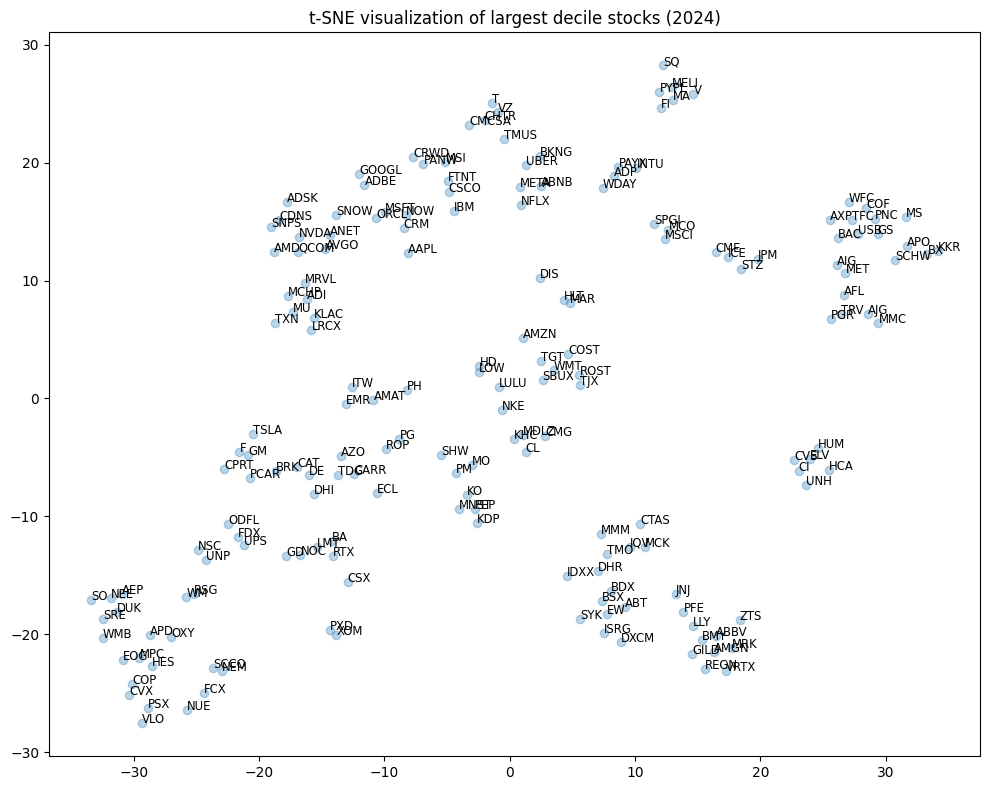

In [78]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(Z[:, 0], Z[:, 1], color="C0", alpha=.3)
for text, x, y in zip(tickers, Z[:, 0], Z[:, 1]):
    ax.annotate(text=text, xy=(x, y), fontsize='small')
ax.set_title(f"t-SNE visualization of largest decile stocks ({enddate//10000})")
plt.tight_layout()

### DBSCAN clustering

**DBSCAN (Density-Based Spatial Clustering of Applications with Noise)** is an unsupervised clustering algorithm that detects clusters of varying densities and identifies outliers. Unlike k-means, it does not require a predefined number of clusters. Instead, it uses two parameters: epsilon (ε) and the minimum number of points required to form a dense region.

In [79]:
# eps is the most important parameter for DBSCAN
eps = 4
db = cluster.DBSCAN(eps=eps)   # default eps

db.fit(Z)
n_clusters = len(set(db.labels_).difference({-1}))
n_noise = np.sum(db.labels_ == -1)
DataFrame(dict(clusters=n_clusters, noise=n_noise, eps=eps),  index=['DBSCAN'])

,clusters,noise,eps
DBSCAN,12,19,4


Visualize DBSCAN clusters in 2D space. Display outlier ticker symbols with larger font sizes:

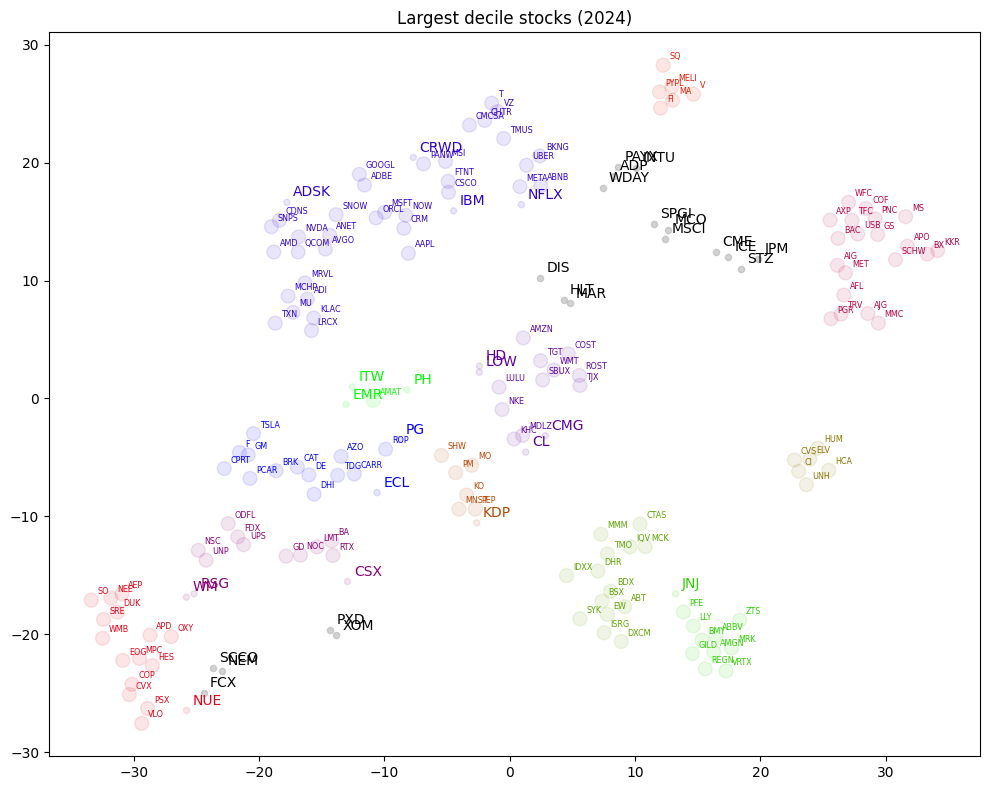

In [80]:
cmap = ColorMap(n_clusters)
fig, ax = plt.subplots(figsize=(10, 8))
# plot core samples with larger marker size
ax.scatter(Z[db.core_sample_indices_, 0],
           Z[db.core_sample_indices_, 1],
           c=cmap[db.labels_[db.core_sample_indices_]],
           alpha=.1, s=100, edgecolors=None)
# plot non-core samples with smaller marker size
non_core = np.ones_like(db.labels_, dtype=bool)
non_core[db.core_sample_indices_] = False
non_core[db.labels_ < 0] = False
ax.scatter(Z[non_core, 0], Z[non_core, 1], c=cmap[db.labels_[non_core]],
           alpha=.1, s=20, edgecolors=None)
# plot noise samples 
ax.scatter(Z[db.labels_ < 0, 0], Z[db.labels_ < 0, 1], c="darkgrey",
           alpha=.5, s=20, edgecolors=None)

# annotate with tickers not in core samples
for i, (t, c, xy) in enumerate(zip(tickers, db.labels_, Z)):
    if i in db.core_sample_indices_:
        ax.annotate(text=t, xy=xy+.5, color=cmap[c], fontsize='xx-small')
    elif c == -1:
        ax.annotate(text=t, xy=xy+.5, color='black', fontsize='medium')
    else:
        ax.annotate(text=t, xy=xy+.5, color=cmap[c], fontsize='medium')
ax.set_title(f"Largest decile stocks ({enddate//10000})")
plt.tight_layout()

List companies tagged as noisy samples:

In [87]:
print("Samples tagged as noise:")
univ.loc[np.array(permnos)[db.labels_ < 0]].sort_values('naics')

Samples tagged as noise:


,cap,capco,decile,nyse,siccd,prc,naics,comnam,ticker
permno,,,,,,,,,
75241,5.246653e+07,5.246653e+07,1,True,1311,224.88,211120,PIONEER NATURAL RESOURCES CO,PXD
21207,4.770164e+07,4.770164e+07,1,True,1041,41.39,212220,NEWMONT CORP,NEM
81774,6.104440e+07,6.104440e+07,1,True,1021,42.57,212230,FREEPORT MCMORAN INC,FCX
82800,6.654158e+07,6.654158e+07,1,True,1021,86.07,212230,SOUTHERN COPPER CORP,SCCO
69796,4.440053e+07,4.440053e+07,1,True,2084,241.75,312130,CONSTELLATION BRANDS INC,STZ
11850,4.005332e+08,4.005332e+08,1,True,2911,99.98,324110,EXXON MOBIL CORP,XOM
78975,1.749684e+08,1.749684e+08,1,False,7370,625.03,513210,INTUIT INC,INTU
26403,1.652592e+08,1.652592e+08,1,True,4833,90.29,516120,DISNEY WALT CO,DIS
44644,9.568078e+07,9.568078e+07,1,False,7374,232.97,518210,AUTOMATIC DATA PROCESSING INC,ADP


### UMAP vizualization

**UMAP (Uniform Manifold Approximation and Projection)** is a dimensionality reduction technique that constructs a high-dimensional graph of data points and optimizes a lower-dimensional representation while preserving essential relationships. Compared to t-SNE, UMAP is faster, scales better for large datasets, and retains more global structure.

[UMAP Documentation](https://umap-learn.readthedocs.io/en/latest/index.html)



In [82]:
import umap
Z = umap.UMAP(n_components=2, n_jobs=1, min_dist=0.0, random_state=42)\
        .fit_transform(vecs)

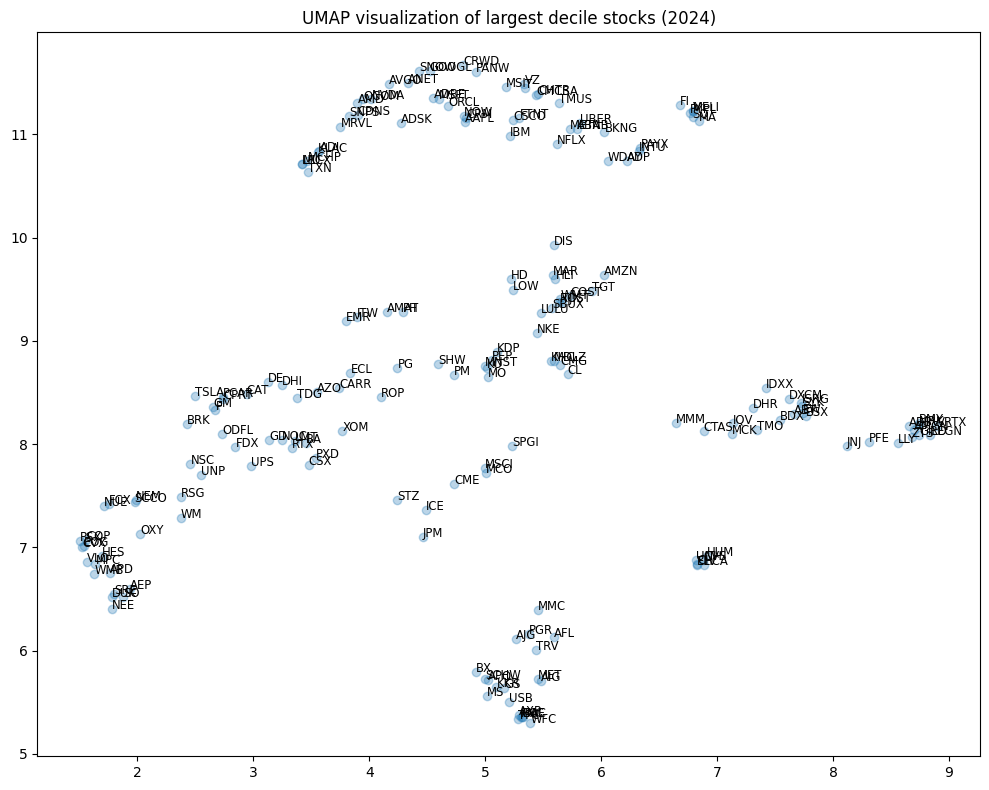

In [83]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(Z[:, 0], Z[:, 1], color="C0", alpha=.3)
for text, x, y in zip(tickers, Z[:, 0], Z[:, 1]):
    ax.annotate(text=text, xy=(x, y), fontsize='small')
ax.set_title(f"UMAP visualization of largest decile stocks ({enddate//10000})")
plt.tight_layout()

### HDBSCAN clustering

**HDBSCAN (Hierarchical Density-Based Spatial Clustering of Applications with Noise)** extends DBSCAN by varying the epsilon parameter and optimizing cluster stability. This makes it more robust to variations in density and parameter selection.


In [84]:
# eps is the most important parameter for DBSCAN
hdb = cluster.HDBSCAN()
hdb.fit(Z)
n_clusters = len(set(hdb.labels_).difference({-1}))
n_noise = np.sum(hdb.labels_ == -1)
DataFrame(dict(clusters=n_clusters, noise=n_noise),  index=['HDBSCAN'])

,clusters,noise
HDBSCAN,14,32


Visualize HDBSCAN clusters in 2D space. Display outlier ticker symbols with larger font sizes.

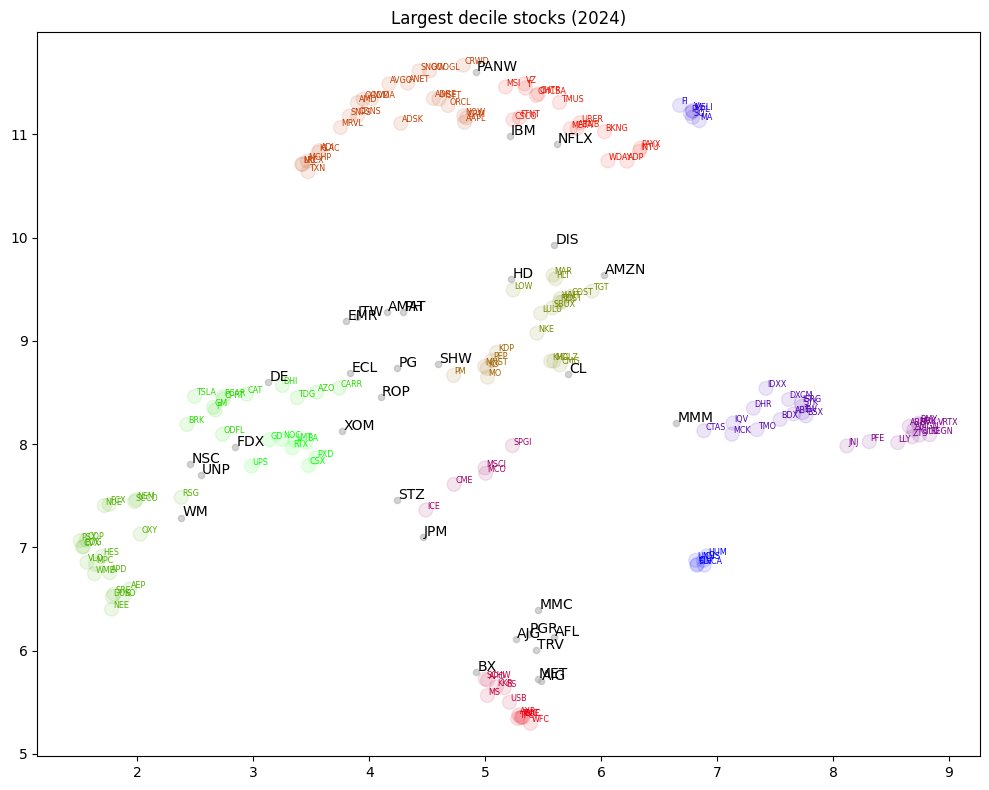

In [85]:
cmap = ColorMap(n_clusters)
fig, ax = plt.subplots(figsize=(10, 8))
# plot core samples with larger marker size
ax.scatter(Z[hdb.labels_ >= 0, 0],
           Z[hdb.labels_ >= 0, 1],
           c=cmap[hdb.labels_[hdb.labels_ >= 0]],
           alpha=.1, s=100, edgecolors=None)
# plot noise samples 
ax.scatter(Z[hdb.labels_ < 0, 0], Z[hdb.labels_ < 0, 1], c="darkgrey",
           alpha=.5, s=20, edgecolors=None)

# annotate with tickers not in core samples
for i, (t, c, xy) in enumerate(zip(tickers, hdb.labels_, Z)):
    if c >= 0:
        ax.annotate(text=t, xy=xy+.01, color=cmap[c], fontsize='xx-small')
    else:
        ax.annotate(text=t, xy=xy+.01, color="black", fontsize='medium')
ax.set_title(f"Largest decile stocks ({enddate//10000})")
plt.tight_layout()

List companies tagged as noisy samples

In [86]:
print("Samples tagged as noise:")
univ.loc[np.array(permnos)[hdb.labels_ < 0]].sort_values('naics')

Samples tagged as noise:


,cap,capco,decile,nyse,siccd,prc,naics,comnam,ticker
permno,,,,,,,,,
69796,4.440053e+07,4.440053e+07,1,True,2084,241.75,312130,CONSTELLATION BRANDS INC,STZ
11850,4.005332e+08,4.005332e+08,1,True,2911,99.98,324110,EXXON MOBIL CORP,XOM
36468,7.983580e+07,7.983580e+07,1,True,2851,311.90,325510,SHERWIN WILLIAMS CO,SHW
70578,5.655752e+07,5.655752e+07,1,True,2841,198.35,325611,ECOLAB INC,ECL
18163,3.453781e+08,3.453781e+08,1,True,2844,146.54,325620,PROCTER & GAMBLE CO,PG
18729,6.563098e+07,6.563098e+07,1,True,2844,79.71,325620,COLGATE PALMOLIVE CO,CL
22103,5.548783e+07,5.548783e+07,1,True,3491,97.33,332911,EMERSON ELECTRIC CO,EMR
19350,1.120656e+08,1.120656e+08,1,True,3523,399.87,333111,DEERE & CO,DE
14702,1.345954e+08,1.345954e+08,1,False,3550,162.07,333248,APPLIED MATERIALS INC,AMAT


**References:**

Greg Durrett, 2023, "CS388 Natural Language Processing course materisl", retrieved from https://www.cs.utexas.edu/~gdurrett/courses/online-course/materials.html

Text-Based Network Industries and Endogenous Product Differentiation.
Gerard Hoberg and Gordon Phillips, 2016, Journal of Political Economy 124 (5), 1423-1465.

Product Market Synergies and Competition in Mergers and Acquisitions: A Text-Based Analysis.
Gerard Hoberg and Gordon Phillips, 2010, Review of Financial Studies 23 (10), 3773-3811. 